In [6]:
import ast

import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.transforms
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import wandb

import sys

# Add the directory two levels up to Python path
project_root = os.path.dirname(os.path.dirname(os.path.abspath(".")))
sys.path.insert(0, project_root)

import src.analyze
import src.globals
import src.plot

refresh = False
# refresh = True


__file__ = "/Users/jkazdan/Documents/Research/memorization/KoyejoLab-Memorization-Scoring-vs-Sampling/notebooks/04_pretraining_loss_scaling/data_analysis.ipynb"
data_dir, results_dir = src.analyze.setup_notebook_dir(
    notebook_dir=os.path.dirname(os.path.abspath(__file__)),
    refresh=False,
)

sweep_ids = [
    "66oov9k1",  # Qwen 3   34M     Finished.
    # "",  # Qwen 3   48M
    "2cdw9bff",  # Qwen 3   62M     Running.
    # "",  # Qwen 3   93M
    "t6opvpa3",  # Qwen 3  153M     Running.
    "ro4lmq0x",  # Qwen 3  342M     Running.
]
# sweep_ids = [
#     "ydhftukf",  # Qwen 3   34M     Finished.
#     "lmom5q7l",  # Qwen 3   48M     Finished.
#     "2oz7fjvg",  # Qwen 3   62M     Running.
#     "iu35ywbi",  # Qwen 3  342M     Running.
# ]

# TODO: Check whether there are NaNs in the data, and if so, debug why.
pt_run_configs_df: pd.DataFrame = src.analyze.download_wandb_pretraining_runs_configs(
    wandb_project_path="memorization-scoring-vs-sampling-pt",
    data_dir=data_dir,
    sweep_ids=sweep_ids,
    refresh=refresh,
    wandb_username=wandb.api.default_entity,
    finished_only=True,
)

data = pt_run_configs_df

Reading /Users/jkazdan/Documents/Research/memorization/KoyejoLab-Memorization-Scoring-vs-Sampling/notebooks/04_pretraining_loss_scaling/data/43bce56c5b3db7fbdab964899d0f783e_runs_configs.csv from disk.
Loaded /Users/jkazdan/Documents/Research/memorization/KoyejoLab-Memorization-Scoring-vs-Sampling/notebooks/04_pretraining_loss_scaling/data/43bce56c5b3db7fbdab964899d0f783e_runs_configs.csv from disk.
% of successfully finished runs: 70.30% (71 / 101)


In [8]:
data.head()

,_runtime,_step,_timestamp,_wandb.runtime,eval/benchmark_loss,eval/benchmark_runtime,eval/benchmark_samples_per_second,eval/benchmark_steps_per_second,eval/eval_loss,eval/eval_runtime,...,Benchmark Subset Fraction,Benchmark Subset Num. Tokens,Num. Epochs,Num. Replicas,Model,Num. Parameters,Num. Tokens,FLOP (6ND),benchmark_loss,eval_loss
0,5003.0,1739.0,1.758030e+09,5003.0,2.547221,1.6801,297.600,7.142,5.507847,637.2084,...,0.10000,150000.0,1.0,100.0,Qwen3/Qwen3-34M,34061856.0,4.903281e+08,1.002089e+17,2.547221,5.507847
2,56320.0,11239.0,1.758062e+09,56320.0,0.035552,7.6103,657.006,14.980,3.088703,472.6071,...,1.00000,1500000.0,1.0,316.0,Qwen3/Qwen3-344M,344023616.0,5.043663e+09,1.041084e+19,0.035552,3.088703
3,13018.0,2735.0,1.758072e+09,13018.0,1.171868,1.5960,313.280,8.772,4.430024,799.6110,...,0.10000,150000.0,1.0,100.0,Qwen3/Qwen3-62M,62873440.0,9.016087e+08,3.401234e+17,1.171868,4.430024
4,12853.0,2650.0,1.758071e+09,12853.0,4.161329,1.6235,307.976,8.623,4.429301,797.0640,...,0.10000,150000.0,1.0,1.0,Qwen3/Qwen3-62M,62873440.0,8.975569e+08,3.385949e+17,4.161329,4.429301
5,4960.0,1644.0,1.758060e+09,4960.0,5.274364,0.8792,179.702,4.549,5.517234,639.7773,...,0.03162,47430.0,1.0,10.0,Qwen3/Qwen3-34M,34061856.0,4.862842e+08,9.938245e+16,5.274364,5.517234


In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set mako as the global palette
sns.set_palette("mako")

In [10]:
# get the means for each of the baseline runs

# First compute the means for Num. Replicas == 0
filtered_means = (
    data[data["Num. Replicas"] == 0].groupby("model/num_parameters")["eval_loss"].mean()
)

# Then map these means back to all rows based on their model/num_parameters
data["Eval. Loss Differences"] = data["eval_loss"] - data["model/num_parameters"].map(
    filtered_means
)

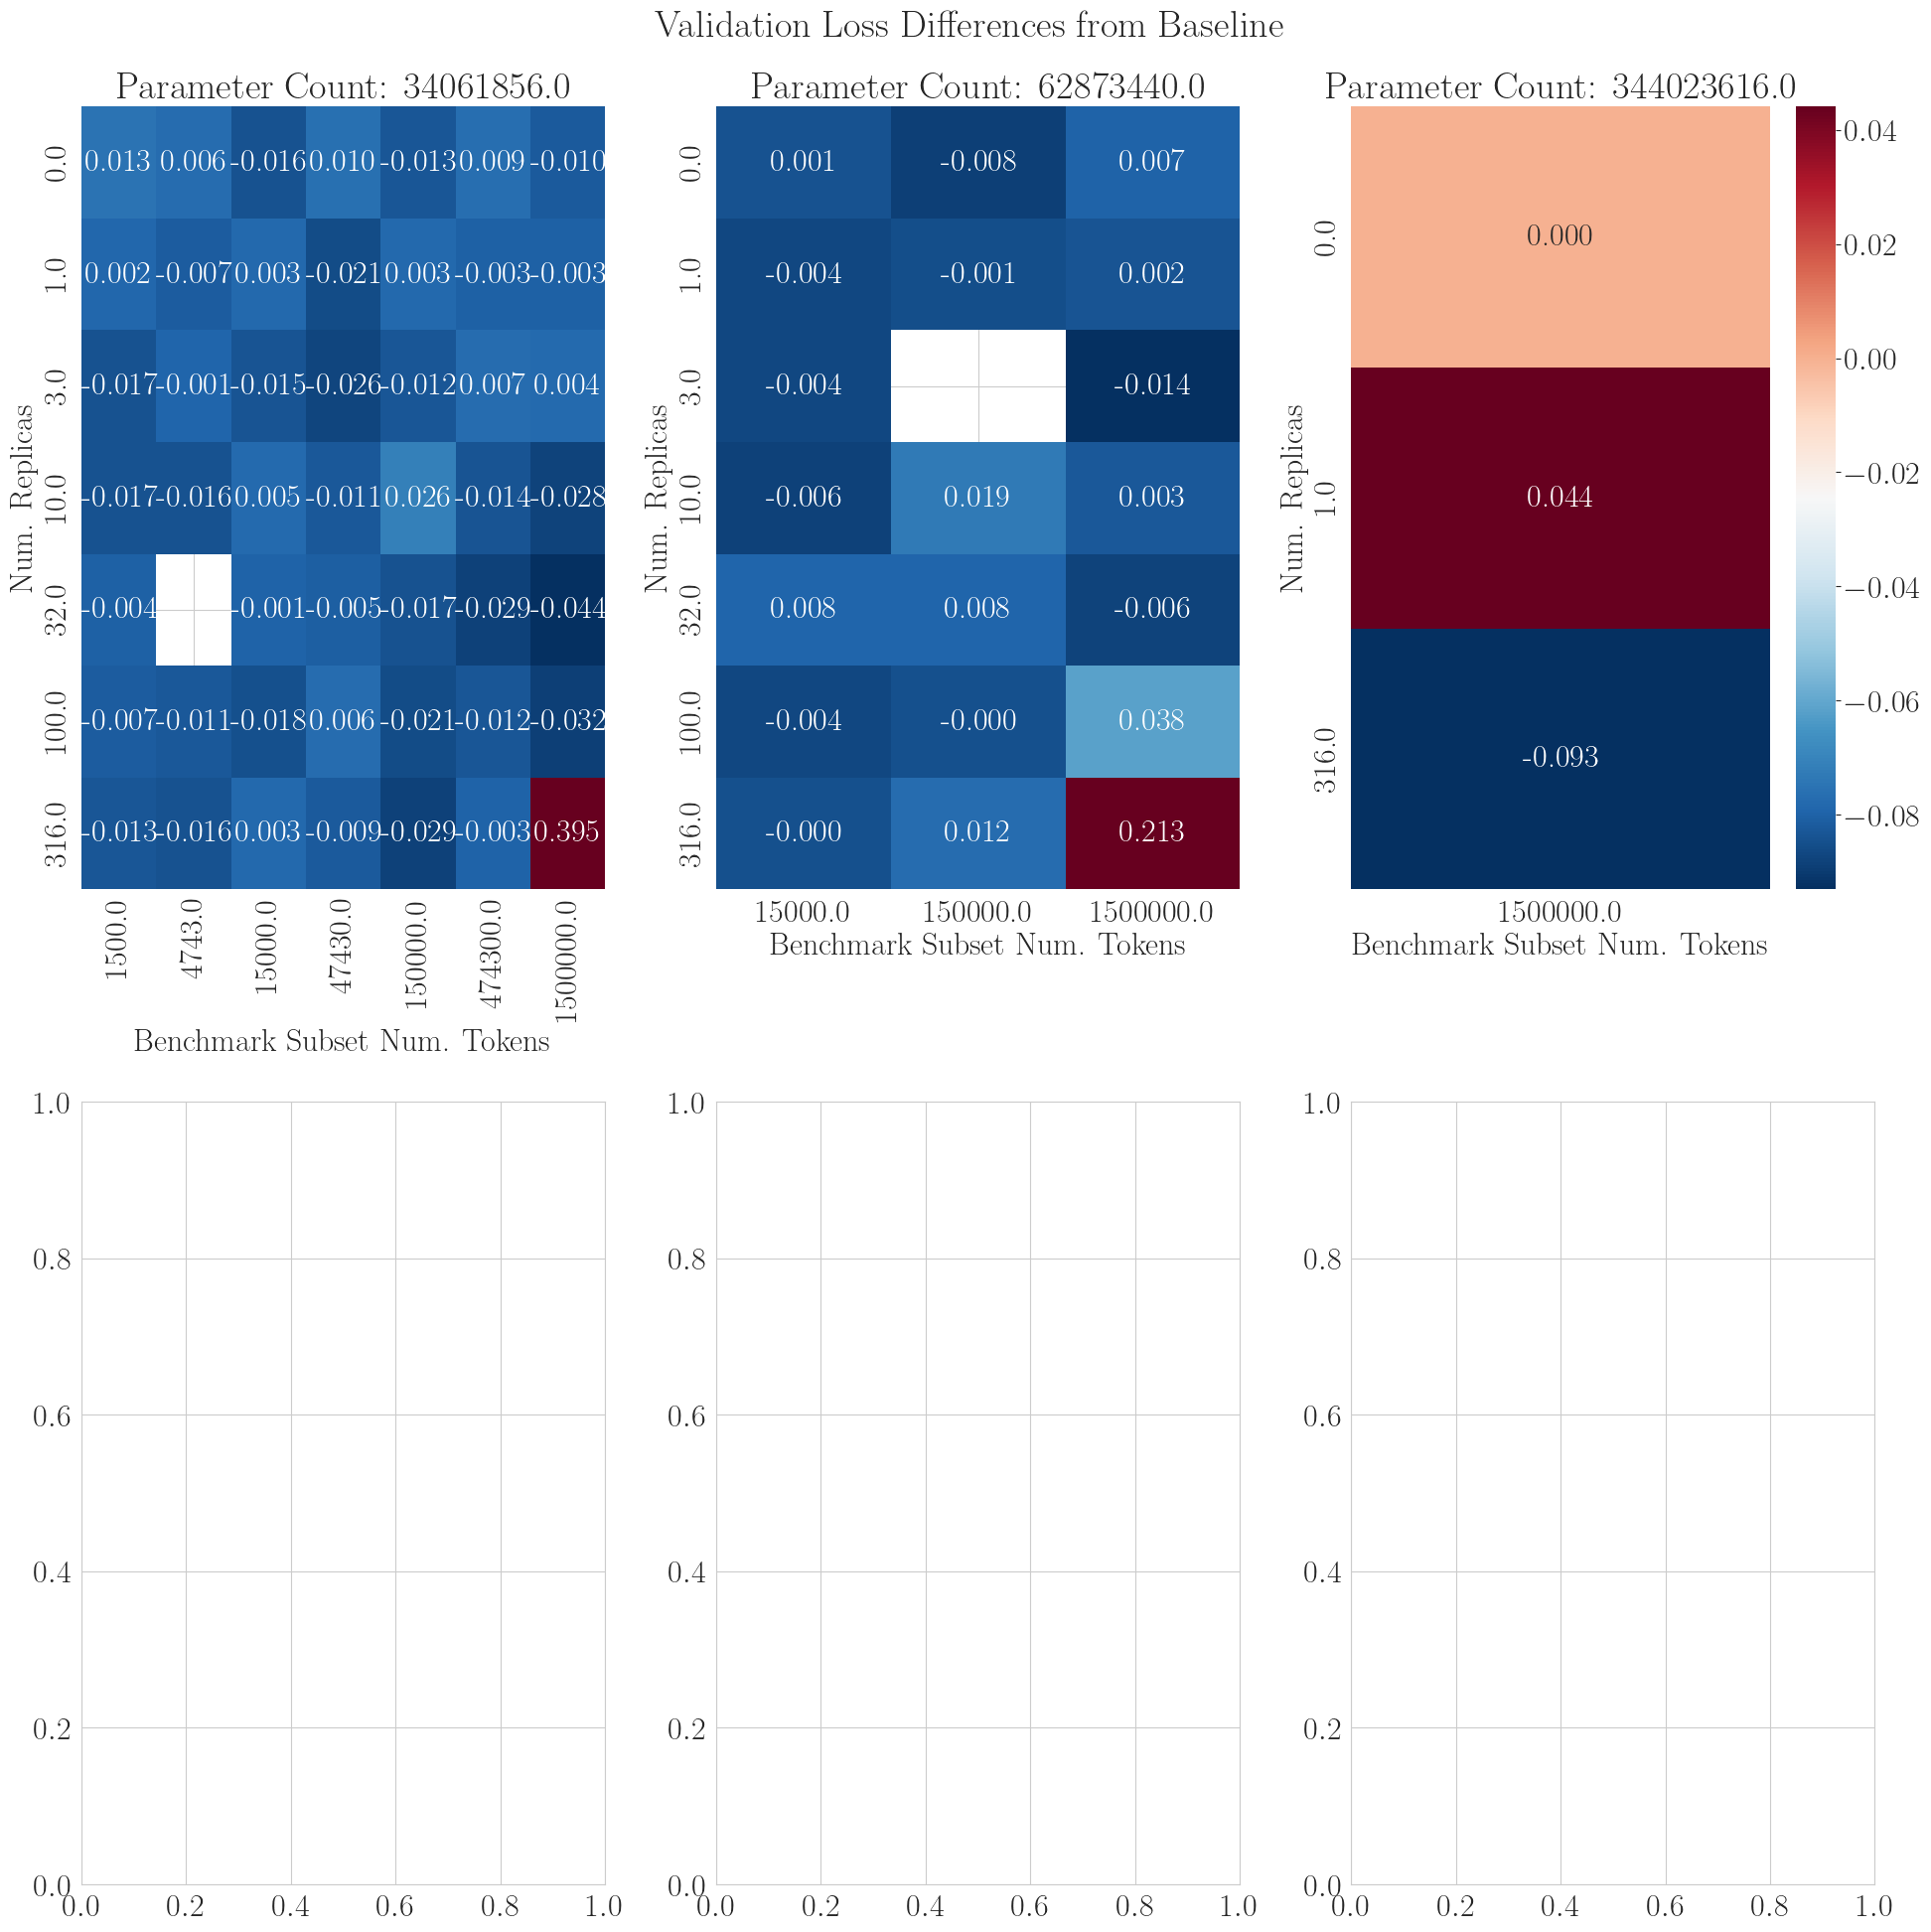

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

# Get the means for each of the baseline runs (Num. Replicas == 0)
filtered_means = (
    data[data["Num. Replicas"] == 0].groupby("model/num_parameters")["eval_loss"].mean()
)

# Calculate the differences from baseline
data["Eval. Loss Differences"] = data["eval_loss"] - data["model/num_parameters"].map(
    filtered_means
)

parameter_counts = data["model/num_parameters"].unique()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 20), sharey=False)

# Flatten the axes array to make indexing easier
axes = axes.flatten()

# Calculate global min/max for consistent color scale
all_differences = data["Eval. Loss Differences"].dropna()
vmin = all_differences.min()
vmax = all_differences.max()

# Use log normalization if all values are positive, otherwise use linear
if vmin > 0:
    norm = LogNorm(vmin=vmin, vmax=vmax)
else:
    norm = None

for i, parameter_count in enumerate(sorted(parameter_counts)):
    df = data[data["model/num_parameters"] == parameter_count]
    heatmap_data = df.pivot_table(
        index="Num. Replicas",
        columns="Benchmark Subset Num. Tokens",
        values="Eval. Loss Differences",
    )

    # Create heatmap with original settings
    sns.heatmap(
        heatmap_data,
        ax=axes[i],
        annot=True,
        fmt=".3f",
        cmap="RdBu_r",
        norm=norm,
        cbar=True if i == len(parameter_counts) - 1 else False,
    )

    axes[i].set_title(f"Parameter Count: {parameter_count}")
    axes[i].set_xlabel("Benchmark Subset Num. Tokens")
    axes[i].set_ylabel("Num. Replicas")

fig.suptitle("Validation Loss Differences from Baseline")
plt.tight_layout()
plt.show()

In [12]:
print(data.columns.to_list())

['_runtime', '_step', '_timestamp', '_wandb.runtime', 'eval/benchmark_loss', 'eval/benchmark_runtime', 'eval/benchmark_samples_per_second', 'eval/benchmark_steps_per_second', 'eval/eval_loss', 'eval/eval_runtime', 'eval/eval_samples_per_second', 'eval/eval_steps_per_second', 'eval_after/epoch', 'eval_after/eval_benchmark_loss', 'eval_after/eval_benchmark_runtime', 'eval_after/eval_benchmark_samples_per_second', 'eval_after/eval_benchmark_steps_per_second', 'eval_after/eval_eval_loss', 'eval_after/eval_eval_runtime', 'eval_after/eval_eval_samples_per_second', 'eval_after/eval_eval_steps_per_second', 'eval_after/num_input_tokens_seen', 'total_flos', 'train/epoch', 'train/global_step', 'train/grad_norm', 'train/learning_rate', 'train/loss', 'train/num_input_tokens_seen', 'train/train_tokens_per_second', 'train_loss', 'train_runtime', 'train_samples_per_second', 'train_steps_per_second', 'accelerator_config', 'adafactor', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'add_cross_attention', '

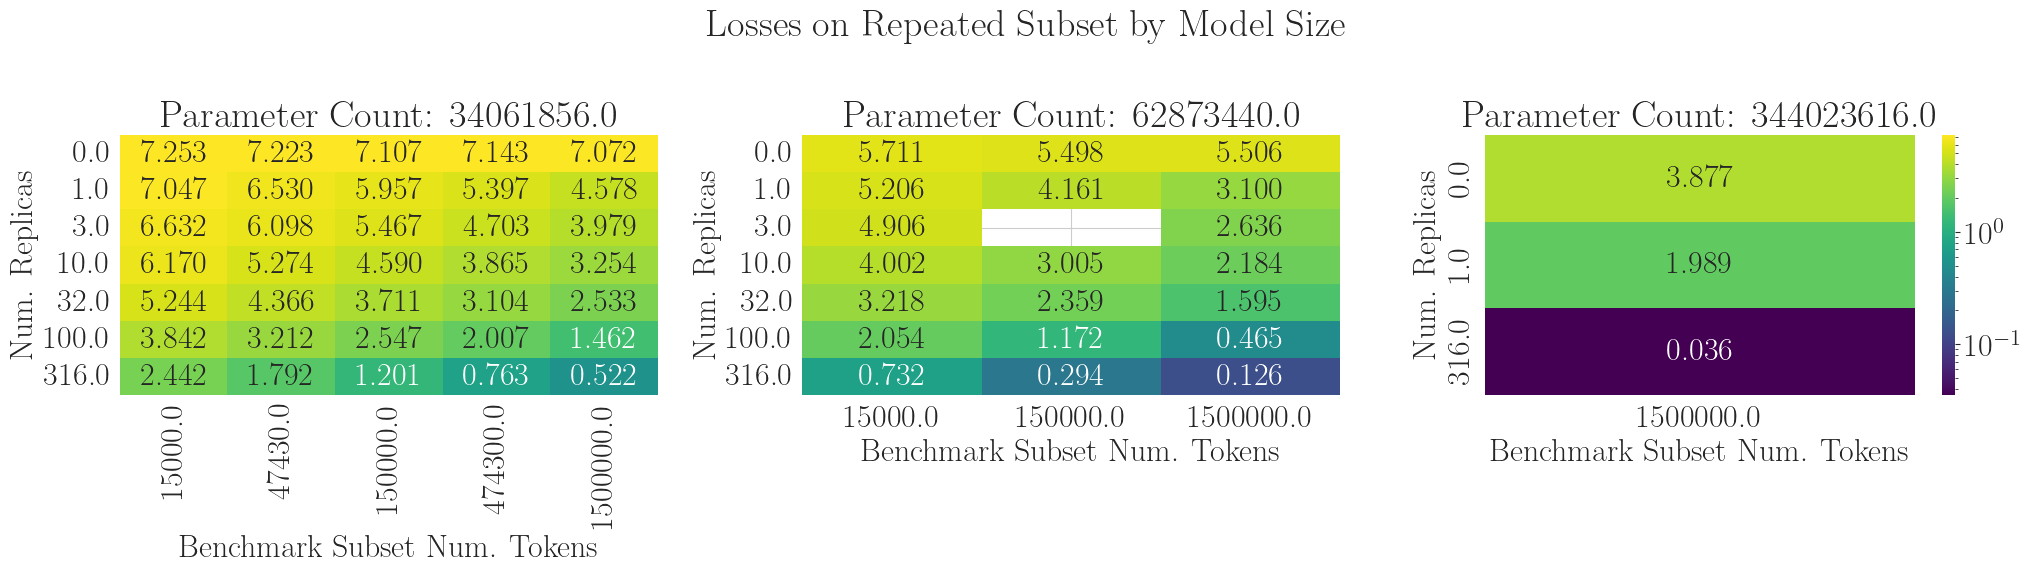

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

# Get unique parameter counts and determine number of subplots needed
parameter_counts = sorted(data["model/num_parameters"].unique())
num_models = len(parameter_counts)

# Calculate grid dimensions (max 3 columns)
ncols = min(3, num_models)
nrows = (num_models + ncols - 1) // ncols  # Ceiling division

# Create subplots in grid layout
fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(7 * ncols, 6 * nrows), sharey=False
)

# Handle different cases for axes indexing
if num_models == 1:
    axes = [axes]
elif nrows == 1:
    axes = axes  # Already a 1D array
else:
    axes = axes.flatten()  # Flatten 2D array to 1D for easier indexing

# Calculate global min/max for consistent color scale
all_losses = data[
    "benchmark_loss"
].dropna()  # Changed from 'eval_loss' to 'benchmark_loss'
vmin = all_losses.min()
vmax = all_losses.max()

# Use log normalization
norm = LogNorm(vmin=vmin, vmax=vmax)

for i, parameter_count in enumerate(parameter_counts):
    df = data[data["model/num_parameters"] == parameter_count]
    heatmap_data = df.pivot_table(
        index="Num. Replicas",
        columns="Benchmark Subset Num. Tokens",
        values="benchmark_loss",
    )

    # Create heatmap with consistent log color scale
    sns.heatmap(
        heatmap_data,
        ax=axes[i],
        annot=True,
        fmt=".3f",
        norm=norm,
        cmap="viridis",
        cbar=True if i == num_models - 1 else False,
    )  # Only show colorbar on last plot

    axes[i].set_title(f"Parameter Count: {parameter_count}")
    axes[i].set_xlabel("Benchmark Subset Num. Tokens")

    # Only label y-axis on leftmost plots
    if i % ncols == 0:
        axes[i].set_ylabel("Num. Replicas")

# Hide any unused subplots
for j in range(num_models, len(axes)):
    axes[j].set_visible(True)

fig.suptitle("Losses on Repeated Subset by Model Size")
plt.tight_layout()
plt.show()

Parameter count 34061856.0:
Num Replicas range: 0.0 to 316.0
Unique token values: [1500.0, 4743.0, 15000.0, 47430.0, 150000.0, 474300.0, 1500000.0]
Parameter count 62873440.0:
Num Replicas range: 0.0 to 316.0
Unique token values: [15000.0, 150000.0, 1500000.0]
Parameter count 344023616.0:
Num Replicas range: 0.0 to 316.0
Unique token values: [1500000.0]


/var/folders/sc/fyw6v7ks5mnfw0twp1p1k4mr0000gn/T/ipykernel_72808/3929281161.py:42: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[i].set_xlim(x_min - 0.05 * (x_max - x_min), x_max + 0.05 * (x_max - x_min))


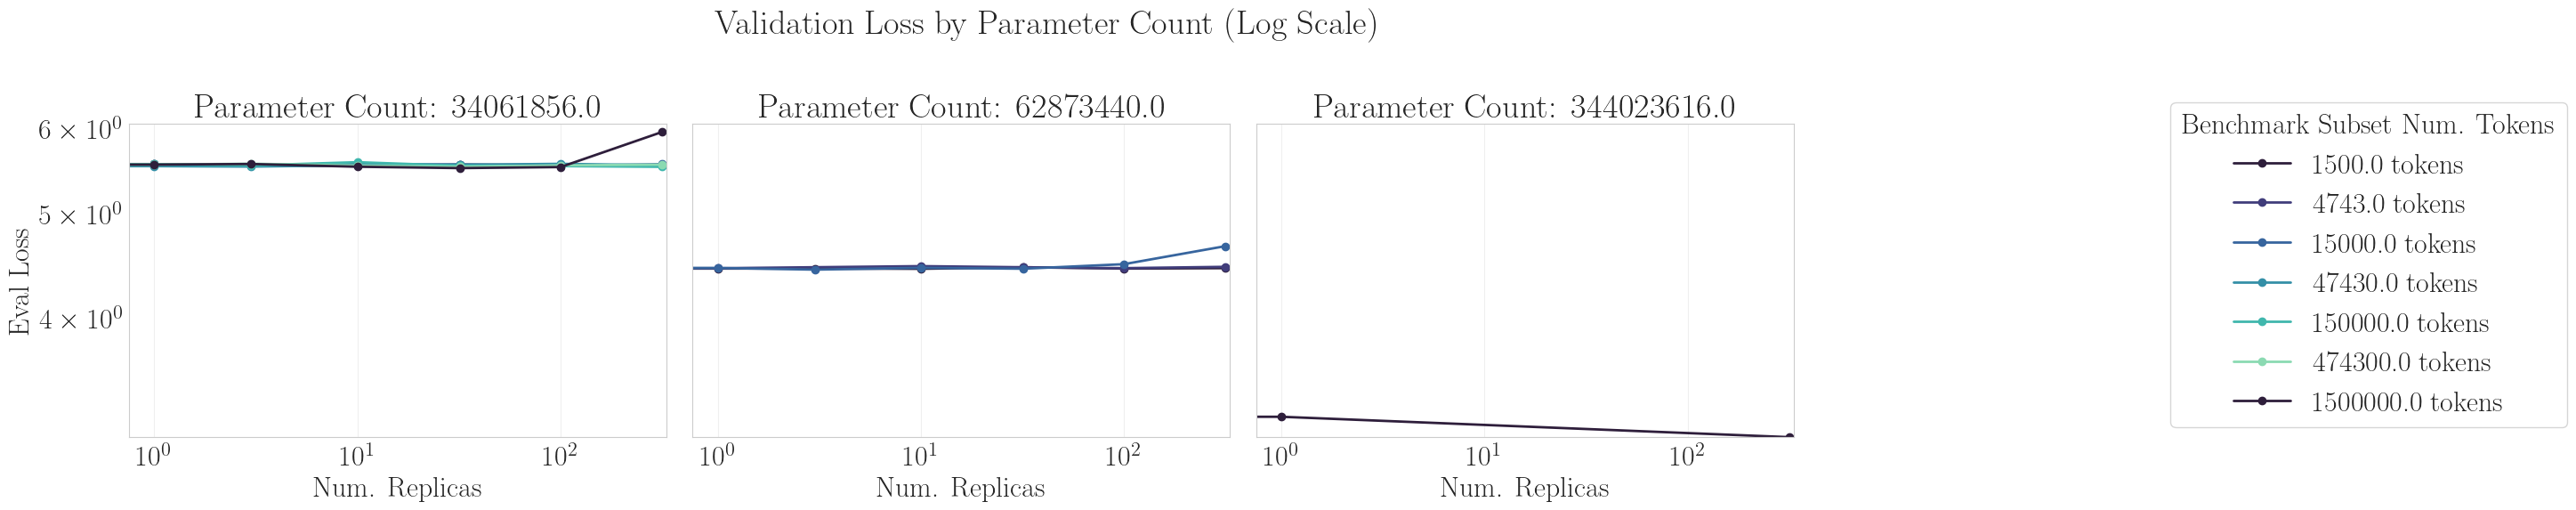

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

parameter_counts = data["model/num_parameters"].unique()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6), sharey=True)

# Calculate global min/max for consistent y-axis scale
all_losses = data["eval_loss"].dropna()
ymin = all_losses.min()
ymax = all_losses.max() + 0.1

# Get unique token values for consistent legend
token_values = sorted(data["Benchmark Subset Num. Tokens"].unique())

for i, parameter_count in enumerate(sorted(parameter_counts)):
    df = data[data["model/num_parameters"] == parameter_count]

    # Debug: print data info
    print(f"Parameter count {parameter_count}:")
    print(
        f"Num Replicas range: {df['Num. Replicas'].min()} to {df['Num. Replicas'].max()}"
    )
    print(f"Unique token values: {sorted(df['Benchmark Subset Num. Tokens'].unique())}")

    # Plot each token value as a separate line manually for better control
    for token_val in token_values:
        subset = df[df["Benchmark Subset Num. Tokens"] == token_val].copy()
        if not subset.empty:
            subset = subset.sort_values("Num. Replicas")  # Ensure sorted
            axes[i].plot(
                subset["Num. Replicas"],
                subset["eval_loss"],
                marker="o",
                label=f"{token_val} tokens",
                linewidth=2,
            )

    axes[i].set_title(f"Parameter Count: {parameter_count}")
    axes[i].set_xlabel("Num. Replicas")
    axes[i].set_ylabel("Eval Loss" if i == 0 else "")
    axes[i].set_yscale("log")
    axes[i].set_xscale("log")
    axes[i].set_ylim(ymin, ymax)
    axes[i].grid(True, alpha=0.3)

    # Set x-axis limits to avoid lines going outside
    x_min, x_max = df["Num. Replicas"].min(), df["Num. Replicas"].max()
    axes[i].set_xlim(x_min - 0.05 * (x_max - x_min), x_max + 0.05 * (x_max - x_min))

# Create legend from the first subplot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Benchmark Subset Num. Tokens",
    bbox_to_anchor=(1.02, 0.5),
    loc="center left",
)

fig.suptitle("Validation Loss by Parameter Count (Log Scale)")
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for legend
plt.show()

Parameter count 34061856.0:
Num Replicas range: 0.0 to 316.0
Unique token values: [1500.0, 4743.0, 15000.0, 47430.0, 150000.0, 474300.0, 1500000.0]
Parameter count 62873440.0:
Num Replicas range: 0.0 to 316.0
Unique token values: [15000.0, 150000.0, 1500000.0]
Parameter count 344023616.0:
Num Replicas range: 0.0 to 316.0
Unique token values: [1500000.0]


/var/folders/sc/fyw6v7ks5mnfw0twp1p1k4mr0000gn/T/ipykernel_72808/2701644096.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[i].set_xlim(x_min - 0.05 * (x_max - x_min), x_max + 0.05 * (x_max - x_min))


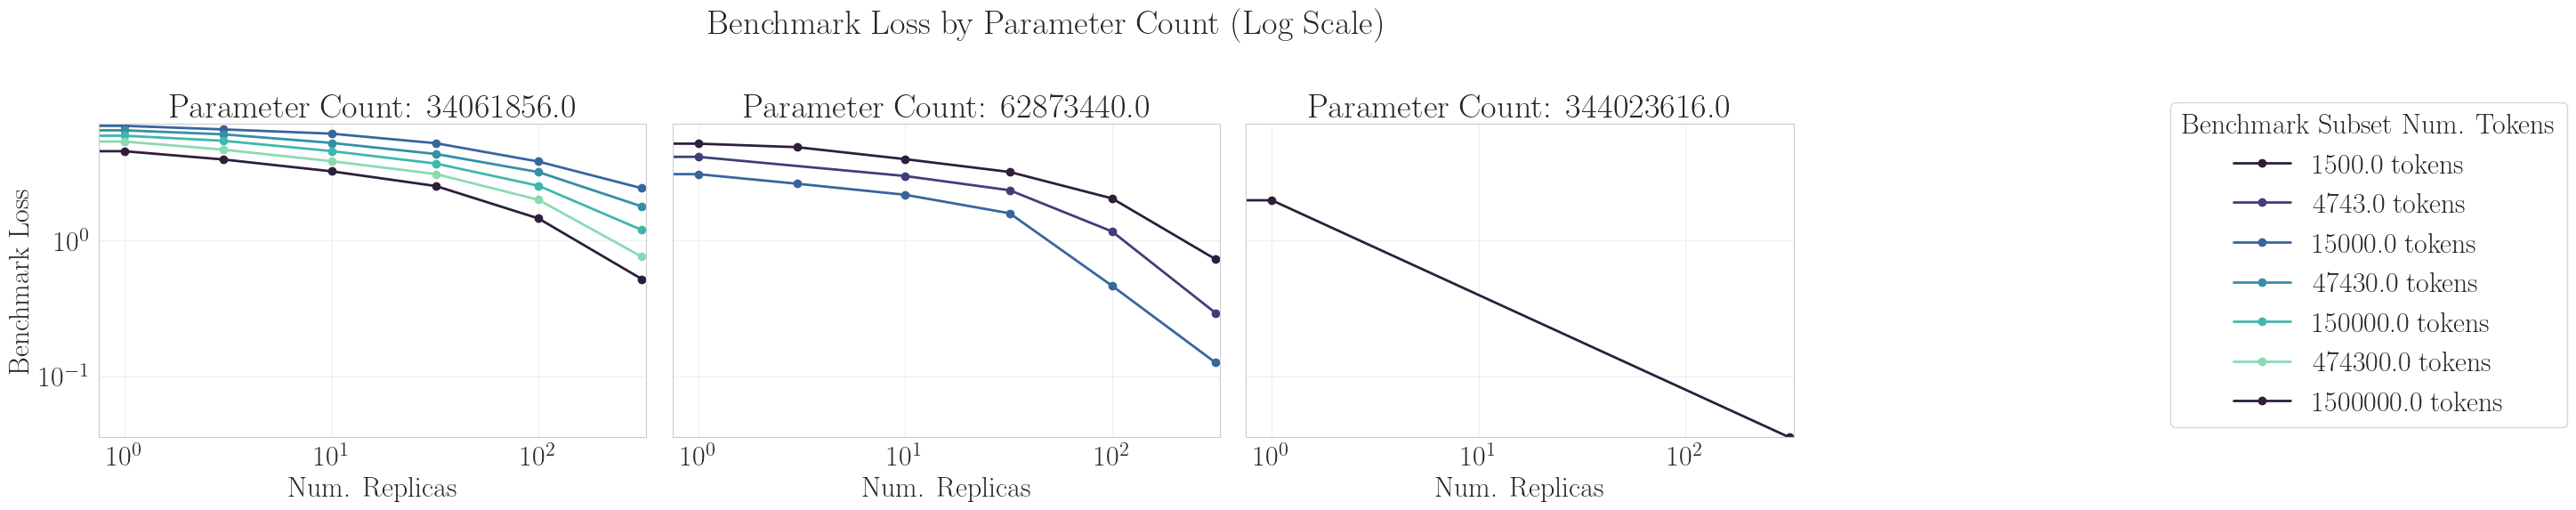

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

parameter_counts = data["model/num_parameters"].unique()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6), sharey=True)


# Calculate global min/max for consistent y-axis scale
all_losses = data["benchmark_loss"].dropna()
ymin = all_losses.min()
ymax = all_losses.max()

# Get unique token values for consistent legend
token_values = sorted(data["Benchmark Subset Num. Tokens"].unique())

for i, parameter_count in enumerate(sorted(parameter_counts)):
    df = data[data["model/num_parameters"] == parameter_count]

    # Debug: print data info
    print(f"Parameter count {parameter_count}:")
    print(
        f"Num Replicas range: {df['Num. Replicas'].min()} to {df['Num. Replicas'].max()}"
    )
    print(f"Unique token values: {sorted(df['Benchmark Subset Num. Tokens'].unique())}")

    # Plot each token value as a separate line manually for better control
    for token_val in token_values:
        subset = df[df["Benchmark Subset Num. Tokens"] == token_val].copy()
        if not subset.empty:
            subset = subset.sort_values("Num. Replicas")  # Ensure sorted
            axes[i].plot(
                subset["Num. Replicas"],
                subset["benchmark_loss"],
                marker="o",
                label=f"{token_val} tokens",
                linewidth=2,
            )

    axes[i].set_title(f"Parameter Count: {parameter_count}")
    axes[i].set_xlabel("Num. Replicas")
    axes[i].set_ylabel("Benchmark Loss" if i == 0 else "")
    axes[i].set_yscale("log")
    axes[i].set_xscale("log")
    axes[i].set_ylim(ymin, ymax)
    axes[i].grid(True, alpha=0.3)

    # Set x-axis limits to avoid lines going outside
    x_min, x_max = df["Num. Replicas"].min(), df["Num. Replicas"].max()
    axes[i].set_xlim(x_min - 0.05 * (x_max - x_min), x_max + 0.05 * (x_max - x_min))

# Create legend from the first subplot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Benchmark Subset Num. Tokens",
    bbox_to_anchor=(1.02, 0.5),
    loc="center left",
)

fig.suptitle("Benchmark Loss by Parameter Count (Log Scale)")
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for legend
plt.show()

Parameter count 34061856.0:
Num Replicas range: 0.0 to 316.0
Unique token values: [1500.0, 4743.0, 15000.0, 47430.0, 150000.0, 474300.0, 1500000.0]
Parameter count 62873440.0:
Num Replicas range: 0.0 to 316.0
Unique token values: [15000.0, 150000.0, 1500000.0]
Parameter count 344023616.0:
Num Replicas range: 0.0 to 316.0
Unique token values: [1500000.0]


/var/folders/sc/fyw6v7ks5mnfw0twp1p1k4mr0000gn/T/ipykernel_72808/3562281876.py:43: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[i].set_xlim(x_min - 0.05 * (x_max - x_min), x_max + 0.05 * (x_max - x_min))


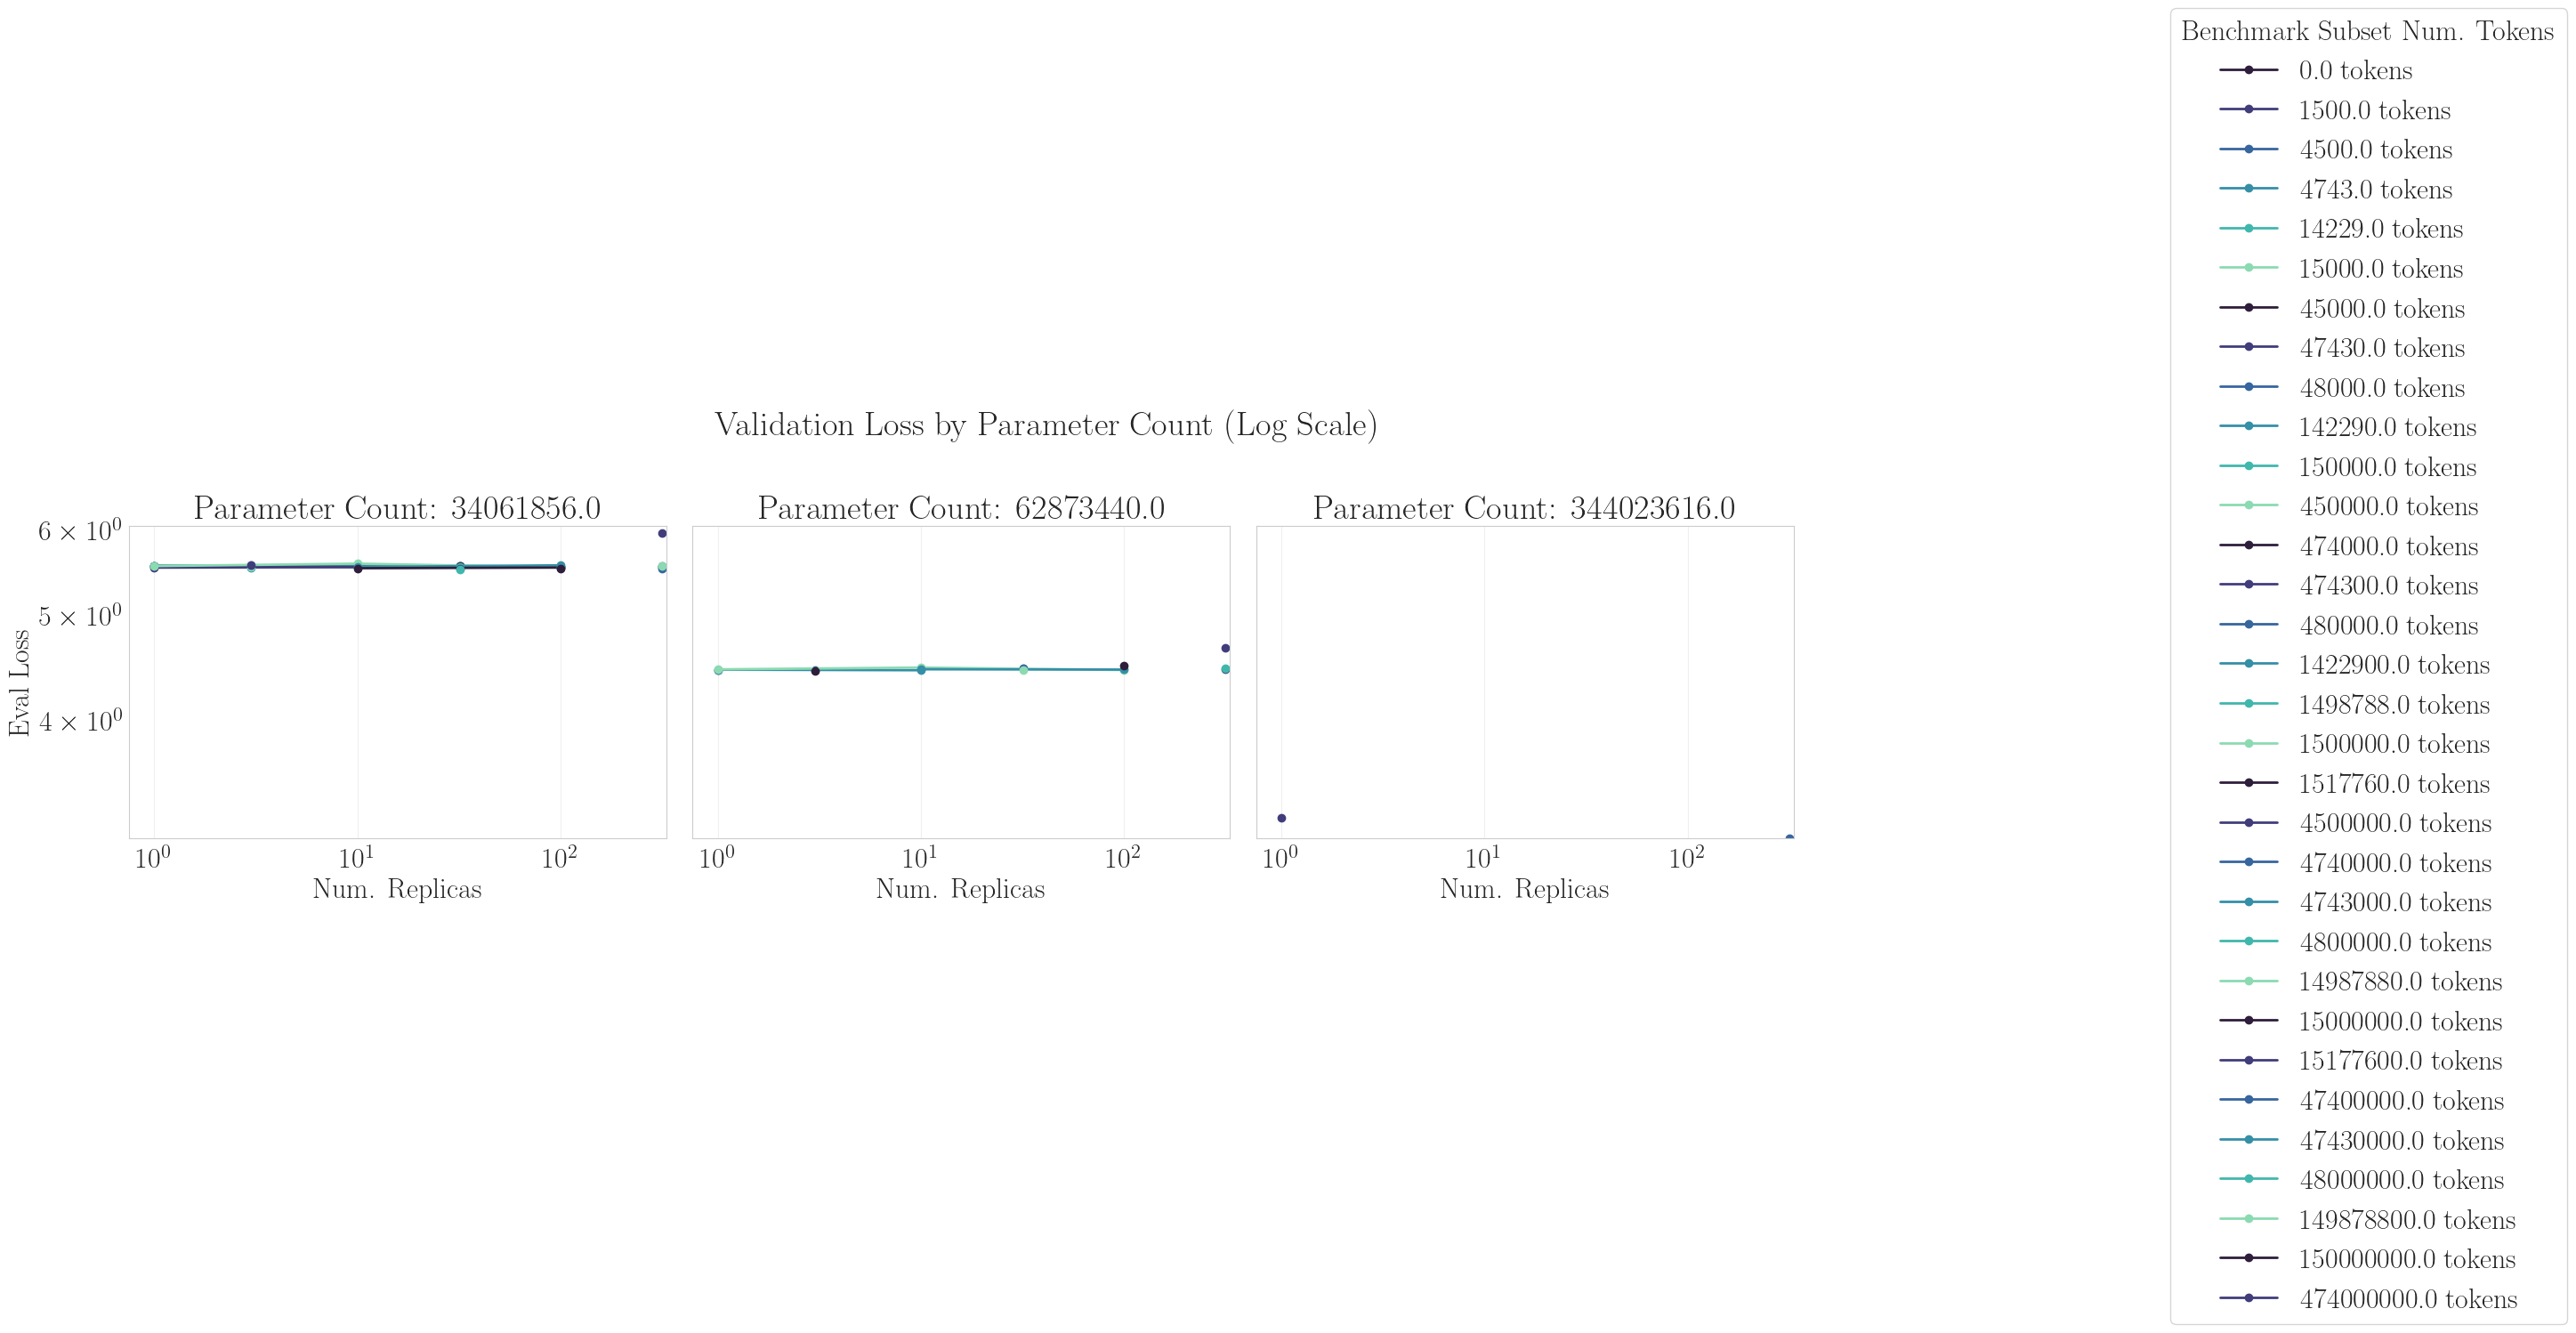

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

parameter_counts = data["model/num_parameters"].unique()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6), sharey=True)

data["replicates_times_num_replicated"] = (
    data["Num. Replicas"] * data["Benchmark Subset Num. Tokens"]
)
# Calculate global min/max for consistent y-axis scale
all_losses = data["eval_loss"].dropna()
ymin = all_losses.min()
ymax = all_losses.max() + 0.1

# Get unique token values for consistent legend
token_values = sorted(data["replicates_times_num_replicated"].unique())

for i, parameter_count in enumerate(sorted(parameter_counts)):
    df = data[data["model/num_parameters"] == parameter_count]

    # Debug: print data info
    print(f"Parameter count {parameter_count}:")
    print(
        f"Num Replicas range: {df['Num. Replicas'].min()} to {df['Num. Replicas'].max()}"
    )
    print(f"Unique token values: {sorted(df['Benchmark Subset Num. Tokens'].unique())}")

    # Plot each token value as a separate line manually for better control
    for token_val in token_values:
        subset = df[df["replicates_times_num_replicated"] == token_val].copy()
        if not subset.empty:
            subset = subset.sort_values("Num. Replicas")  # Ensure sorted
            axes[i].plot(
                subset["Num. Replicas"],
                subset["eval_loss"],
                marker="o",
                label=f"{token_val} tokens",
                linewidth=2,
            )

    axes[i].set_title(f"Parameter Count: {parameter_count}")
    axes[i].set_xlabel("Num. Replicas")
    axes[i].set_ylabel("Eval Loss" if i == 0 else "")
    axes[i].set_yscale("log")
    axes[i].set_xscale("log")
    axes[i].set_ylim(ymin, ymax)
    axes[i].grid(True, alpha=0.3)

    # Set x-axis limits to avoid lines going outside
    x_min, x_max = df["Num. Replicas"].min(), df["Num. Replicas"].max()
    axes[i].set_xlim(x_min - 0.05 * (x_max - x_min), x_max + 0.05 * (x_max - x_min))

# Create legend from the first subplot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Benchmark Subset Num. Tokens",
    bbox_to_anchor=(1.02, 0.5),
    loc="center left",
)

fig.suptitle("Validation Loss by Parameter Count (Log Scale)")
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for legend
plt.show()